In [216]:
import pandas as pd
import seaborn as sns
df = pd.read_excel('/Users/miaoli/Desktop/policy/labelled news.xlsx')

## load & cleaning data

### prepare datasest

In [218]:
policy_area = ['Democracy, Government, & Politics', 'Diversity & Inclusion',
       'Economic and Financial Policy', 'Education Policy',
       'Energy & Environmental Policy', 'Globalization & Economic Development',
       'Health Policy & Access', 'International Policy & Global Conflict',
       'Technology Policy & Cybersecurity', 'Social Policy & Inequality',
       'Urban Policy & Crime',]

In [219]:
df1 = df.loc[:,['Article Title', 'URL',]]

In [220]:
for area in policy_area:
    df.loc[~(df.loc[:,area].isna()), area] = 1
    df.loc[df.loc[:,area].isna(), area] = 0

In [221]:
df1 = df.drop(columns = ['Date Published',
       'Prior Degree Institute and Dept./School','Chicago & Community Engagement',
       'Public Leadership & Management', 'Scholarship & Impact','What\'s New at Harris', 'tag'])

In [222]:
df2 = df1.dropna(subset=['Article Title'])

In [223]:
#distribution of label
label = pd.DataFrame()
for area in policy_area:
    label.loc[area, 'Frequency'] = df2[area].sum()


<Axes: xlabel='Freq', ylabel='Area'>

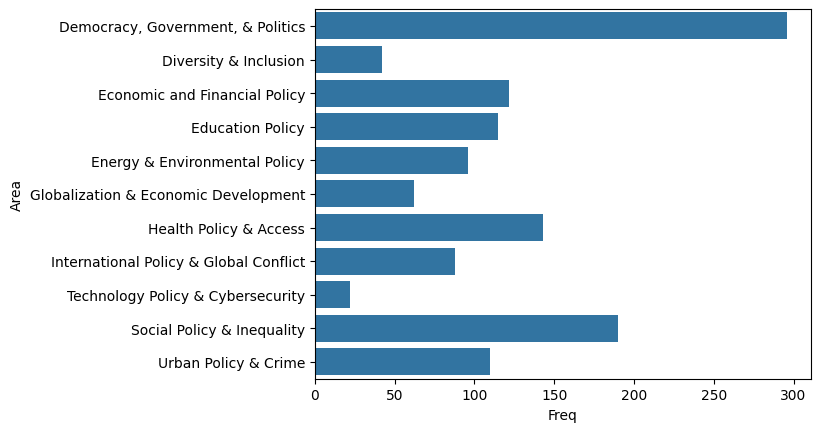

In [224]:
label_reset = label.reset_index()
label_reset.columns = ['Area', 'Freq']
sns.barplot(x='Freq', y='Area', data=label_reset)

### cleaning

In [225]:
import nltk
default_stopwords = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()

In [252]:
def clean_title(title):
    tokens = nltk.tokenize.word_tokenize(title)
    txt = [word.lower() for word in tokens if ((word.isalpha())| ('covid' in word.lower()))]
    words_lc = [word for word in txt if word not in default_stopwords]
    lst = [wnl.lemmatize(token) for token in words_lc]
    
    return ' '.join(lst)

In [251]:
title = '10 Pieces of COVID-19 News from Harris Public'
tokens = nltk.tokenize.word_tokenize(title)
txt = [word.lower() for word in tokens if ((word.isalpha())| ('covid' in word.lower()))]
txt

['pieces', 'of', 'covid-19', 'news', 'from', 'harris', 'public']

In [253]:
df2.loc[:,'clean_title'] = df2.loc[:,'Article Title'].apply(clean_title)

## Model building

### pick top three most frequent 

In [240]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [241]:
def build_log(area, vect_type):
    X = df2.loc[:,'clean_title']
    y = df2.loc[:,area]
    X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size = 0.2, random_state=123)
    if vect_type == 'count':
        vect = CountVectorizer(ngram_range=(1,3))
    elif vect_type == 'tfidf':
        vect = TfidfVectorizer(ngram_range=(1,3))
    logreg = LogisticRegression().fit(vect.fit_transform(X_train), y_train)
    y_pred = logreg.predict(vect.transform(X_test))
    print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")
    print(classification_report(y_test, y_pred))

    feature_names = vect.get_feature_names_out()
    coefs_with_fns = zip(feature_names, logreg.coef_[0])

    #show coefficients
    coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                        columns=['feature', 'coefficient'])
    coefs_with_fns_df.sort_values('coefficient', ascending=False, inplace=True)
    print(coefs_with_fns_df.head(10))

    return logreg, vect

def show_coef(vect, model):
    feature_names = vect.get_feature_names_out()
    coefs_with_fns = zip(feature_names, model.coef_[0])

    #show coefficients
    coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                        columns=['feature', 'coefficient'])
    coefs_with_fns_df.sort_values('coefficient', ascending=False, inplace=True)
    print(coefs_with_fns_df.head(10))

def examine_gap(model, vect, text):
    x = vect.transform(text)
    res = model.predict_proba(x)

    return [x[1] for x in res][0] #return prob for being labelled as 1


In [254]:
model1, vect1 = build_log('Democracy, Government, & Politics', 'count')
show_coef(vect1, model1)

Test Accuracy: 77.4%
              precision    recall  f1-score   support

           0       0.77      0.98      0.87       174
           1       0.79      0.18      0.29        61

    accuracy                           0.77       235
   macro avg       0.78      0.58      0.58       235
weighted avg       0.78      0.77      0.72       235

          feature  coefficient
7257    political     1.288206
3000     election     1.115986
7281     politics     1.102010
2436    democracy     0.964577
3969   government     0.800813
10438        vote     0.751066
3215    executive     0.673628
10441       voter     0.617782
10013      threat     0.571812
551     announces     0.559770
          feature  coefficient
7257    political     1.288206
3000     election     1.115986
7281     politics     1.102010
2436    democracy     0.964577
3969   government     0.800813
10438        vote     0.751066
3215    executive     0.673628
10441       voter     0.617782
10013      threat     0.571812
5

In [255]:
dem_df = df2.loc[:,['Article Title', 'clean_title','Democracy, Government, & Politics']]
dem_df.loc[:,'pred'] = dem_df.clean_title.apply(lambda x : examine_gap(model1, vect1, [x]))

In [256]:
model2, vect2 = build_log('Health Policy & Access', 'count')

Test Accuracy: 89.4%
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       208
           1       0.75      0.11      0.19        27

    accuracy                           0.89       235
   macro avg       0.82      0.55      0.57       235
weighted avg       0.88      0.89      0.86       235

                     feature  coefficient
4323                  health     1.409408
5436                 latrine     1.345207
2121                   covid     0.939722
4705                   india     0.738286
4332              healthcare     0.719322
304                  alumnus     0.681012
0                         19     0.669601
2122                covid 19     0.669601
6726                  opioid     0.666105
346   alumnus profile claire     0.648577


In [257]:
dem_df = df2.loc[:,['Article Title', 'clean_title','Health Policy & Access']]
dem_df.loc[:,'pred'] = dem_df.clean_title.apply(lambda x : examine_gap(model2, vect2, [x]))

In [258]:
dem_df.loc[dem_df.loc[:,'Health Policy & Access'] == 1, :].sort_values('pred', ascending = True)

,Article Title,clean_title,Health Policy & Access,pred
956,Harris Welcomes New Faculty for 2019-2020,harris welcome new faculty,1,0.028449
789,Harris Policy Forum: Valerie Jarrett and Helen...,harris policy forum valerie jarrett helene gay...,1,0.029916
399,"Student Profile: Dominic DeCoster, MPP Class o...",student profile dominic decoster mpp class,1,0.042129
609,Anticipation Grows for Dr. Fauci's Visit to Ha...,anticipation grows fauci visit harris public p...,1,0.044323
900,"Harris Scholars to Present Research, Share Exp...",harris scholar present research share expertis...,1,0.047162
...,...,...,...,...
349,Dean Katherine Baicker Discusses the Importanc...,dean katherine baicker discus importance insur...,1,0.923292
1195,"Incoming Student Profile: David Kline, Double ...",incoming student profile david kline double ex...,1,0.926512
63,New Research from Dean Katherine Baicker Explo...,new research dean katherine baicker explores u...,1,0.956833
438,Dean Katherine Baicker to Co-Chair Policy Tran...,dean katherine baicker policy translation work...,1,0.961179
